#  LSTMs/GRUs e a CTC

Até agora, usamos células em RNNs que consistiam de neurônios artificiais tradicionais. Agora, vamos passar a usar células que implementam memória de um ponto de vista funcional. Elas podem ser usadas no lugar de qualquer célula/unidade tradicional de uma RNN, sendo responsável por ler, escrever ou lembrar de informação fluindo no modelo. 

A LSTM, em particular, consiste basicamente de uma unidade linear (a celula de informação propriamente dita) envoltas por três portas lógicas, responsáveis pela manutenção dos dados. Uma é responsável por permitir que dados fluam para a célulade informação (entrada), uma pela saída da célula e a última é responável por lembrar ou esquecer de dados de acordo com as necessidades da rede. A GRU é uma versão mais simplificada da LSTM. Ela combina portas da LSTM em menos portas, produzindo um modelo menor.

Estas unidades ajuam a resolver o problema de manter estados, porque a rede pode escolher esquecê-los se já não servem mais. Desta forma, o problema dos gradientes é menos importantes com LSTMs e GRUs. De fato, LSTMs e GRUs são tão convenientes que, na prática, pouco se usam RNNs com células que não sejam estas.

Nesta aula, vamos usar LSTMs em problemas de reconhecimento de escrita.

### Arquitetura Long Short-Term Memory 

Neste texto, vamos considerar que uma LSTM é formada por três portas lógicas: "Input" ou "Write", responsável pela escrita na LSTM de dados vindos do resto da RNN; "Output" ou "Read", responsável pela saída da LSTM para o resto da RNN; e "Keep" ou "Forget", rsponsável pela manutenção ou modificação de dados armazenados na LSTM.

<img src=https://ibm.box.com/shared/static/zx10duv5egw0baw6gh2hzsgr8ex45gsg.png width="720"/>
<center>*Diagrama de uma Long Short-Term Memory Unit*</center>

Se você estiver mais interssado em saber sobre LSTMs e suas variantes, incluindo GRUs, leia o blog: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

# Connectionist Temporal Classification

Um típico pipeline de reconhecimento temporal, em deep learning, envolve uma rede neural para reconhecimento combinada com algum mecanismo que garanta a consistência no tempo.

Por exemplo, na imagem abaixo, temos a representação de uma arquitetura usada em reconhecimento de fala. Nela, os componente neurais (os módulos em azul) são responsáveis por identificar o fonema apartir de algum sinal de entrada (o espectograma, features MEL ou o sinal puro de som, observados em um _frame_ de som). O componente de consistência temporal (no exemplo, a barra roxa que representa a função CTC, mas poderia ser uma HMM), por sua vez, lida com a sequência de possíveis fonemas sendo identificados para entender o que está sendo dito em geral. Em suma, este componente trata do contexto geral.

![](images/ctc1.png)

Em redes neurais, uma possibilidade para o componente temporal é a função CTC (Connectionist Temporal Classification) proposta por Alex Graves para o problema de reconhecimento de escrita manual (ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf).

Tomando como exemplo o problema de escrita manual, imagine que o usuário escreveu 'dançar'.

![](images/dancar.png)

Digamos que o nosso modelo está reconhecendo a terceira letra da palavra como sendo "u". Podemos dizer que o modelo está aproximando a probabilidade $p$(${\bf y}$ = 'u' | ${\bf x}$ = segmento de imagem correspondente à terceira letra em dançar) como a convicção que a rede neural, que está observando aquele segmento de imagem, tem de se tratar de um 'u'. Contudo, o correto seria 'n', algo que pode ser observado pelo contexto todo da palavra, já que 'dançar' é muito mais provavelmente uma palavra do Português que 'dauçar'.

Assim, em vez de aprender uma letra por vez, é melhor aprender a sequência de letras que faz mais sentido.

Cada sequência pode ser vista como um caminho (representado por $\pi$) que passa por cada letra reconhecida em cada instante no tempo (com saída softmax $y_{\pi_t}$). Assim, a probabilidade de uma sequência observada ao longo de $T$ instantes de tempo pode ser descrita como:

$$p(\pi|{\bf x}) = \prod_{t}^{T}{y_{\pi_t}}$$

Ou seja, a probabilidade é dada pelo produto das saídas softmax ao longo de $T$.

#### Dynamic Time Warping

Mas por que precisamos fazer isso? Afinal, uma RNN/LSTM/GRU já não considera seu passado quando emite uma saída? Sim, mas na prática, nem sempre é simples dizer onde começam e terminam segmentos, nem qual o tamanho 'certo' de uma letra, nem mesmo garantir que as entradas não sejam superpostas. Para lidar com estes problemas, temos duas alternativas:

* rotular cada instante no tempo e também descrever onde, mais ou menos, começam e terminam as letras -- hmm, não parece algo muito legal de fazer, né?
* rotular uma sequência inteira e deixar a rede advinhar como ela se segmenta -- aqui é onde entra a CTC!

Dado o rótulo geral $\ell$ (por exemplo, $\ell$ = 'dançar' para a imagem acima), a CTC corresponde à estimativa:

$$p(\ell|{\bf x}) = \sum_{i}{p(\ell|\pi_i) p(\pi_i|{\bf x})}$$

Ou seja, a probabilidade de se ler 'dançar' é a soma das probabilidades de ver dançar em suas várias formas (ou seja, marginalizada em $\pi$), sendo cada forma ponderada por sua possibilidade de ocorrer dada a entrada. Esse passo é chamado _dynamic time warping_.

Mas como estimar a probabilidade de $p(\ell|{\bf x})$?

#### Estimando a probabilidade do rótulo, dada a entrada

Para estimar $p(\ell|{\bf x})$, vamos usar um algoritmo de programação dinâmica, chamado _forward-backward_. Para compreendê-lo, vamos usar o exemplo dado por Alex Graves em seus artigo sobre a CTC, onde ele decodifica da palavra 'cat'.

![](images/ctc-cat-graves.png)

Na figura, cada linha corresponde a uma letra ou vazio (branco) e cada coluna corresponde a um instante no tempo em que uma parte daquela letra (por exemplo, uma coluna de pixels da letra) está sendo observada. As setas indicam os caminhos a serem tomados em termos de escolha de rótulos. Há três possibilidades de transição em cada instante do tempo: 

* permaneço com o rótulo atual (seta para mesma linha) -- ex: em tempo $t$ vi pixels em 'C'; em tempo $t+1$, continuo vendo pixels, que devem ser de 'C' ainda (mas também poderiam ser de uma letra sobreposta ou ligada); 
* vou para um próximo rótulo (seta para branco) -- ex: em tempo $t$ vi pixels em 'C'; em tempo $t+1$, não vejo mais pixels, o que sugere que 'C' acabou (mas pode não ter acabado -- posso estar apenas vendo o intervalo antes que ela continue, como seria o caso do ideograma 的); e 
* vou para o próximo rótulo previsto -- ex: em tempo $t$ não vejo pixels; em tempo $t+1$, vejo pixels, o que sugere que deve ser uma letra depois de 'C' (ou uma continuação, como vimos acima). 

Deste modo, o rótulo $\ell$ = ['C','A','T'], pode ser visto como $\ell'$ = [$\lambda$,'C',$\lambda$,'A',$\lambda$,'T',$\lambda$], onde $\lambda$ indica um rótulo vazio (branco).

A ideia chave para estimar $p(\ell|{\bf x})$ é que a soma sobre os caminhos correspondentes a uma rotulação pode ser decomposta em uma soma iterativa correspondente aos prefixos daquela rotulação. Estas iterações podem ser calculadas de forma eficiente com variáveis recursivas $\alpha$ e $\beta$ que correspondem ao visto antes e depois do tempo $t$.

$$p(\ell|{\bf x}) = \sum_{s=1}^{\ell'}{\frac{\alpha_t(s) \beta_t(s)}{y^{(t)}_{\ell'_s}}}$$

Note que $\alpha$ e $\beta$ dependem da saída $y$ da RNN. Assim, durante o treino, cada novo conjunto de previsões da RNN é avaliado usando $p(\ell|{\bf x})$ e os neurônios modificam seus pesos de acordo com o gradiente desta função, dado por: 

$$\frac{\partial p(\ell|{\bf x})}{\partial {y^{(t)}_k}} = \frac{1}{{y^{(t)}_k}^2} \sum_{s | \ell'_s = k}{\alpha_t(s) \beta_t(s)}$$

Para detalhes sobre a CTC, leia o artigo em http://www.cs.toronto.edu/~graves/icml_2006.pdf.

O tensorflow implementa a CTC como `nn.ctc.loss()`. A seguir, temos um exemplo de uso.

In [1]:
#  Compatibility imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline

from six.moves import xrange as range

E:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Para testarmos a CTC, vamos usar uma pequena coleção de imagens que representam os dígitos de 0 a 9. Cada imagem corresponde a uma sequência aleatória de dígitos de comprimento variável (e número de digitos variáveis).

In [3]:
with open('data/test_varlen.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [4]:
print (data['chars'])
print (len(data['chars']))
print ('instances', len(data['x']))
# height and weight for first image
print ('height_0:', len(data['x'][0]))
print ('width_0:', len(data['x'][0][0]))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
10
instances 100
height_0: 9
width_0: 38


Abaixo, podemos ver as primeiras duas sequências de dígitos, uma com 4 dígitos (38 pixels de largura) e outra com 9 dígitos (em 60 pixels de largura). O rótulo correspondente à primeira sequência indica os dígitos que estão presentes (0, 1, 2 e 3). Para a segunda, são 4, 5, 6, 7, 8, 9, 5, 3 e 7. Todas as imagens na coleção têm 8 pixels de altura.

In [5]:
slabs = [(np.asarray(data['x'][i]), np.asarray(data['y'][i])) 
         for i in range(len(data['x']))]

[0 1 2 3]
[4 5 6 7 8 9 5 3 7]


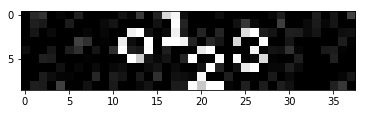

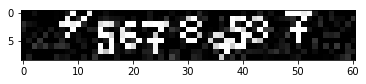

In [6]:
for i in range(2):
    print(slabs[i][1])
    plt.figure()
    plt.imshow(slabs[i][0], cmap = 'gray', interpolation = 'nearest')

A função a seguir lê esta coleção para a memória, fornecendo as sequências, seus rótulos correspondentes e o número de sequências válidas lidas. 

In [9]:
# load the training or test dataset from disk
def get_toy_data(pname):
    with open(pname, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    num_examples = len(data['x'])
    # note that image shape is modified to columns x lines, since it is expected a
    # fixed number of lines and a varying number of columns
    seqs = np.asarray([data['x'][t].swapaxes(0, 1) 
                       for t in range(num_examples) if len(data['y'][t]) > 0])
    # get label seqs
    labs = np.asarray([np.asarray(data['y'][t]) 
                       for t in range(num_examples) if len(data['y'][t]) > 0])
    return seqs, labs, len(labs)

Note que as sequências são transpostas de forma a serem representadas por tantos intervalos de tempo quanto forem as suas larguras e 8 'atributos de entrada' já que isto corresponde a sua altura em pixels.

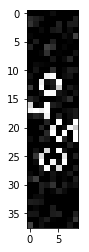

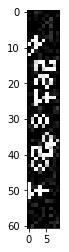

In [10]:
seqs, _, _ = get_toy_data('data/test_varlen.pkl')
for i in range(2):
    plt.figure()
    plt.imshow(seqs[i], cmap = 'gray', interpolation = 'nearest')

A função a seguir é dada apenas por conveniência. Ela permite gerar sequências aleatórias para testar a LSTM que vamos usar. Mas nesta aula vamos usar a coleção toy descrita antes.

In [11]:
# generate synthetical data for training
# useful for testing
def fake_data(num_examples, num_features, num_labels, min_size = 10, max_size=100):

    # Generating different timesteps for each fake data
    timesteps = np.random.randint(min_size, max_size, (num_examples,))

    # Generating random input
    inputs = np.asarray([np.random.randn(t, num_features).astype(np.float32) for t in timesteps])

    # Generating random label, the size must be less or equal than timestep in order to achieve the end of the lattice in max timestep
    labels = np.asarray([np.random.randint(0, num_labels, 
                                           np.random.randint(1, inputs[i].shape[0], (1,))).astype(np.int64) 
                         for i, _ in enumerate(timesteps)])

    return inputs, labels

Para usar a CTC do tensorflow, precisamos colocar as sequências de entrada no formato esparso usado pela função.

In [12]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

Por exemplo, duas sequências de entrada, (0, 1, 3) e (5, 8, 9, 3, 2), serão convertidas para a forma I, V, S, onde I corresponde a uma sequência de pares que indicam o índice da sequência e do valor dentro da sequência; V corresponde às observações correspondentes a cada par; S é um par indicando o número de sequências e o número máximos de valores observados.

In [13]:
sparse_tuple_from([[0,1,3], [5,8,9,3,2]])

(array([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4]], dtype=int64),
 array([0, 1, 3, 5, 8, 9, 3, 2]),
 array([2, 5], dtype=int64))

Como as sequências de entrada podem ter tamanho variável, elas precisam ser preenchidas para terem o mesmo tamanho em um certo batch. A função a seguir faz isso:

In [15]:
def pad_sequences(sequences, maxlen=None, dtype=np.float32,
                  padding='post', truncating='post', value=0.):
    '''Pads each sequence to the same length: the length of the longest sequence.
        If maxlen is provided, any sequence longer than maxlen is truncated to
        maxlen. Truncation happens off either the beginning or the end
        (default) of the sequence. Supports post-padding (default) and
        pre-padding.

        Args:
            sequences: list of lists where each element is a sequence
            maxlen: int, maximum length
            dtype: type to cast the resulting sequence.
            padding: 'pre' or 'post', pad either before or after each sequence.
            truncating: 'pre' or 'post', remove values from sequences larger
            than maxlen either in the beginning or in the end of the sequence
            value: float, value to pad the sequences to the desired value.
        Returns
            x: numpy array with dimensions (number_of_sequences, maxlen)
            lengths: numpy array with the original sequence lengths
    '''
    lengths = np.asarray([len(s) for s in sequences], dtype=np.int64)

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x, lengths

In [16]:
print (pad_sequences([[1,2],[1,2,3,4],[1,2,3]]))
print (pad_sequences([[1,2],[1,2,3,4],[1,2,3]], padding = 'pre'))
print (pad_sequences([[1,2],[1,2,3,4],[1,2,3]], maxlen = 3))

(array([[1., 2., 0., 0.],
       [1., 2., 3., 4.],
       [1., 2., 3., 0.]], dtype=float32), array([2, 4, 3], dtype=int64))
(array([[0., 0., 1., 2.],
       [1., 2., 3., 4.],
       [0., 1., 2., 3.]], dtype=float32), array([2, 4, 3], dtype=int64))
(array([[1., 2., 0.],
       [1., 2., 3.],
       [1., 2., 3.]], dtype=float32), array([2, 4, 3], dtype=int64))


Finalmente, temos a nossa rede, usando uma RNN dinâmica com células LSTM na camada oculta.

In [17]:
tf.reset_default_graph()

# number de pixel in columns
num_features = 9 
# total of digits + blank = 11 symbols
num_classes = 11

# Hyper-parameters
num_hidden = 35
learning_rate = 1e-2

# data
ftrain = 'data/train_varlen.pkl'
input_seqs, seq_labels, num_examples = get_toy_data(ftrain)

In [22]:
# e.g: output of a convolutional net
# Has size [batch_size, max_stepsize, num_features], but the
# batch_size and max_stepsize can vary along each step
inputs = tf.placeholder(tf.float32, [None, None, num_features])
shape = tf.shape(inputs)
batch_s, max_timesteps = shape[0], shape[1]

# Here we use sparse_placeholder that will generate a
# SparseTensor required by ctc_loss op.
targets = tf.sparse_placeholder(tf.int32)

# 1d array of size [batch_size]
seq_len = tf.placeholder(tf.int32, [None])

# Defining the cell
cell = tf.contrib.rnn.LSTMCell(num_hidden, state_is_tuple=True)

# The second output is the last state and we will no use that
outputs, _ = tf.nn.dynamic_rnn(cell, inputs, seq_len, dtype=tf.float32)

# Reshaping to apply the same weights over the timesteps
outputs = tf.reshape(outputs, [-1, num_hidden])

# W init = truncated normal with mean 0 and stdev=0.1
# bias init Zero initialization
W = tf.Variable(tf.truncated_normal([num_hidden,
                                     num_classes],
                                    stddev=0.1))
b = tf.Variable(tf.constant(0., shape=[num_classes]))
### do not include sigmoid because CTC will do that
logits = tf.matmul(outputs, W) + b 

# Reshaping back to the original shape
logits = tf.reshape(logits, [batch_s, -1, num_classes])
# Time major
logits = tf.transpose(logits, (1, 0, 2))

loss = tf.nn.ctc_loss(targets, logits, seq_len)
cost = tf.reduce_mean(loss)
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(cost)

# Option 2: tf.nn.ctc_beam_search_decoder (slower but better)
decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)

# Inaccuracy: label error rate
ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                      targets))
init = tf.global_variables_initializer()
saver = tf.train.Saver()

ValueError: Variable rnn/lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "E:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()
  File "E:\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "E:\Anaconda\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)


Para avaliar e nossa implementação, vamos usar uma função que usa a RNN para estimar o rótulo de uma sequência de entrada e decodifica a saída da RNN em forma de uma sequência. As sequências são exibidas antes das previstas, de forma a avaliar a RNN, tanto em treino quanto teste.

In [ ]:
def show_decoded_seqs(session, X, Y):
    # Padding input to max_time_step of this batch
    Xp, seqlen = pad_sequences(X)

    # Converting to sparse representation so as to to feed SparseTensor input
    Ys = sparse_tuple_from(Y)

    # Decoding
    d = session.run(decoded[0], 
                    feed_dict={inputs: Xp,
                               targets: Ys,
                               seq_len: seqlen})
    d_dense = tf.sparse_tensor_to_dense(d, default_value=-1)
    dense_decoded = d_dense.eval(session=session)
    for i, seq in enumerate(dense_decoded):
        seq = ' '.join([str(s) for s in seq if s != -1])
        print('\t%d %s --> [%s]' % (i, Y[i], seq))

A seguir, treinamos nossa RNN:

In [20]:
# You can preprocess the input data here
Xtrain = input_seqs
Ytrain = seq_labels

batch_size = 5
num_epochs = 10
num_batches_per_epoch = int(num_examples/batch_size)

# random cases to evaluate
cases_to_show = np.random.randint(0, num_examples - 1, (10,))

with tf.Session() as s:
    # Initializate the weights and biases
    init.run()

    for e in range(num_epochs):
        train_cost = train_ler = 0
        for batch in range(num_batches_per_epoch):

            # Getting the index
            indexes = [i % num_examples 
                       for i in range(batch * batch_size, (batch + 1) * batch_size)]
            Xtrain_b = Xtrain[indexes]
            
            # Padding input to max_time_step of this batch
            Xtrain_b, seqlen_train_b = pad_sequences(Xtrain_b)

            # Converting to sparse representation so as to to feed SparseTensor input
            Ytrain_b = sparse_tuple_from(Ytrain[indexes])

            feed = {inputs: Xtrain_b,
                    targets: Ytrain_b,
                    seq_len: seqlen_train_b}
            batch_cost, _ = s.run([cost, optimizer], feed_dict = feed)
            train_cost += batch_cost*batch_size
            train_ler += s.run(ler, feed_dict=feed)*batch_size

        if e % 2 == 0:
            show_decoded_seqs(s, Xtrain[cases_to_show], 
                              Ytrain[cases_to_show])        
            
        # Shuffle the data
        shuffled_indexes = np.random.permutation(num_examples)
        Xtrain = Xtrain[shuffled_indexes]
        Ytrain = Ytrain[shuffled_indexes]

        # Metrics mean
        train_cost /= num_examples
        train_ler /= num_examples

        log = "%2d/%2d, tr_cost = %.3f, tr_ler = %.3f"
        print(log % (e+1, num_epochs, train_cost, train_ler))
    
    saver.save(s, "/tmp/ctc_model")

	0 [2 2 9 6] --> []
	1 [5 8 9 8 4] --> []
	2 [5 4 1 8 3] --> []
	3 [0 6 5 1 5 7] --> []
	4 [2 1 2 9 4] --> []
	5 [9 4 8 5] --> []
	6 [3 0 3 8 5] --> []
	7 [8 7 0 2 7] --> []
	8 [7 5 3 2 0 5 1] --> []
	9 [5 0 1 3] --> []
 1/10, tr_cost = 15.349, tr_ler = 0.996
 2/10, tr_cost = 13.392, tr_ler = 0.996
	0 [1 5 0 4 7] --> [5]
	1 [9 0 3 4 1] --> []
	2 [2 5 6 1 0 0 8 9] --> [5]
	3 [6 3 0 4 4] --> []
	4 [2 4 7 6 0] --> [7]
	5 [4 6 7 8 2 9 0] --> []
	6 [8 3 5 9 1 6] --> [5]
	7 [9 7 3 6 4 7] --> [7 7]
	8 [3 5 7 1 6] --> [5 7]
	9 [8 1 8 5 4] --> [7 5]
 3/10, tr_cost = 12.598, tr_ler = 0.929
 4/10, tr_cost = 11.125, tr_ler = 0.830
	0 [9 5] --> [3 5 5]
	1 [8 7 2 6] --> [8 7 8 6]
	2 [4 0 4 7] --> [4 0 4 7]
	3 [5 1 6 3] --> [5 6 3]
	4 [7 3 1 9] --> [7 3 1 3]
	5 [8 3 4 2] --> [3 3 8]
	6 [0 4 8 9 5] --> [0 8 3 5]
	7 [0 3 8 6] --> [0 3 8 6]
	8 [0 7 5 4] --> [0 7 5 4]
	9 [5 1 8 7 3 9 6 2] --> [5 1 8 7 3 3 6 8]
 5/10, tr_cost = 8.483, tr_ler = 0.602
 6/10, tr_cost = 4.776, tr_ler = 0.278
	0 [5 0 3 1 5] --

Finalmente, testamos em nossa coleção separada de teste:

In [21]:
# Evaluate on test set
ftest = 'data/test_varlen.pkl'
Xtest, Ytest, num_instances = get_toy_data(ftest)
# Padding input to max_time_step of this batch
Xtest_p, seqlen_test_p = pad_sequences(Xtest)
# Converting to sparse representation so as to to feed SparseTensor input
Ytest_s = sparse_tuple_from(Ytest)
# test cases
cases_to_show = np.random.randint(0, num_instances - 1, (10,))

with tf.Session() as s:
    saver.restore(s, "/tmp/ctc_model")
    test_ler = s.run(ler, feed_dict={inputs: Xtest_p,
                                     targets: Ytest_s,
                                     seq_len: seqlen_test_p})
    print ('Evaluation on test set. Error:', test_ler)
    show_decoded_seqs(s, Xtest[cases_to_show], 
                      Ytest[cases_to_show])

INFO:tensorflow:Restoring parameters from /tmp/ctc_model
Evaluation on test set. Error: 0.03181349
	0 [4 2 4 6 2 8] --> [4 8 4 6 2 8]
	1 [5 4 1 3 9 7] --> [5 1 3 9 7]
	2 [6 2 4 1 7] --> [6 2 4 1 7]
	3 [3 1 3 8 0] --> [3 1 3 8 0]
	4 [7 8 6 0 9 2 5] --> [7 8 6 0 9 2 5]
	5 [1 2 7 8 3 5] --> [2 7 8 3 5]
	6 [3 9 0 4] --> [3 9 0 4]
	7 [1 2 7 8 3 5] --> [2 7 8 3 5]
	8 [8 6 9 5 7 2] --> [8 6 9 5 7 2]
	9 [3 9 0 4] --> [3 9 0 4]


Para todos considerando seriamente a função CTC, aconselho a usar a implementação do Baidu, disponibilizada publicamente em https://github.com/baidu-research/warp-ctc e compatível com tensorflow. Ela é usada nos sistemas de reconhecimento de fala do Baidu e é muito mais eficiente que a implementação original do tensorflow para GPUs e CPUs, tanto em termos de tempo quanto estabilidade numérica (ao menos, em setembro de 2017). 

Alternativas à função CTC incluem (a) combinar DNNs com HMMs, mas esta parece ser uma estratégia sendo lentamente substituída, (b) RNNs para transdução de sequências (o modelo de CTC com a inclusão de dependência entre saídas e modelagem de transição de sequências, em outras palavras, um modelo de linguagem -- ver https://arxiv.org/pdf/1211.3711.pdf) e (c) uso de modelos de atenção que incluem no modelo neural o objetivo de aprender a 'olhar' para os 'segmentos' (https://arxiv.org/pdf/1506.07503v1.pdf).

Esta aula foi baseada nos exemplos de Igor Macedo Quintanilha (https://github.com/igormq/ctc_tensorflow_example) e na explicação sobre CTC de Karl N. (https://gab41.lab41.org/speech-recognition-you-down-with-ctc-8d3b558943f0), além de usar dados criados pelo gerador sintético de Rakeshvar https://github.com/rakeshvar/rnn_ctc.